<a href="https://colab.research.google.com/github/pabair/rl-course-ws2020/blob/main/4_PyTorch_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Minimal PyTorch Example



This notebooks shows a very minimal example on how to use PyTorch for training a neural network on the Iris data set.

### 0. Preamble

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn

torch.manual_seed(1)

The following lines checks for GPU availability on the machine and sets the GPU as processing device (if available).
If you are on Colab you can enable GPU support in the menu via  "Runtime > Change runtime type" and select "GPU" as hardware accelerator.

In [2]:
if(torch.cuda.is_available()):
  processing_chip = "cuda:0"
  print(f"{torch.cuda.get_device_name(0)} available")
else:
  processing_chip = "cpu"
  print("No GPU available")

device = torch.device(processing_chip)
device

No GPU available


device(type='cpu')

### 1. Data Preperation

For this small example we use the [Iris flower data set](https://en.wikipedia.org/wiki/Iris_flower_data_set). The data set consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters. Based on these four features, we want to train a model that can predict the species.

In the first step we load the data into a Pandas.

In [3]:
import pandas as pd

url = 'data/iris.csv'
dataset = pd.read_csv(url)
dataset.head(5)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


To be able to train a model, we first need to transform the *species* column into a numeric:

In [4]:
dataset.loc[dataset.species=='Iris-setosa', 'species'] = 0
dataset.loc[dataset.species=='Iris-versicolor', 'species'] = 1
dataset.loc[dataset.species=='Iris-virginica', 'species'] = 2
dataset.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


Next, we specify which columns we want to use as features and which as label:

In [5]:
X = dataset[dataset.columns[0:4]].values
y = dataset.species.values.astype(int)

We then split our data into training and test data.

In [6]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)
print(train_X.shape, test_X.shape)

(120, 4) (30, 4)


To be able to use the data in PyTorch, we need to convert them into PyTorch tensors. Such a tensor can be thought of an efficient way to represent lists and matrices (similar to Numpy), with the additional benefit that they can be moved to the GPU (the `.to(device)` part in the code below) and that they support automatic backpropagation (more on this later):

In [7]:
train_x = torch.Tensor(train_X).float().to(device)
test_x = torch.Tensor(test_X).float().to(device)
train_y =torch.Tensor(train_y).long().to(device)
test_y = torch.Tensor(test_y).long().to(device)

### 2. Model definition
We define now the strucutre of our neural network. For this we create a class that is a subclass from PyTorch's `nn.Module`.
By convention we put in the `__init__` method the layers we want to use in the network and in the `forward` method how data flows through this network.

Our network has 4 input features, 7 hidden layer nodes and 3 output neurons. The hidden layer uses a Relu activation function. Note that the output layer does not have a softmax activation (unlike we have seen it in the lecture). It rather gives out a raw score for each class (more on this later). 


In [8]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.hidden = nn.Linear(4, 7)  
    self.output = nn.Linear(7, 3)

  def forward(self, x):
    z1 = self.hidden(x)
    z2 = F.relu(z1)
    z3 = self.output(z2)  # no softmax. see CrossEntropyLoss() 
    return z3

### 3. Model Training
We can now start training our network. We run several epochs in which we first predict on the training data with our network and than backpropagate the loss. For this we use PyTorch's build-in optimizer that runs gradient descent on the weights of the network. Hence, in every episode we reduce the loss on the training data and improve our network.

As loss function we use cross entropy, which consumes the raw scores from the prediction and internally applies a softmax (that is why we do not need the softmax as last layer in the network).

Note that all training data is passed at once to our network (line `net(train_x)`), since PyTorch will predict on all data points in parallel. 

In [9]:
# create network, move it to device (either CPU or GPU)
net = Net().to(device)

# define the parameters for training
no_epochs = 100
learning_rate = 0.04
loss_func = nn.CrossEntropyLoss()  # applies softmax() internally
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

print("\nStarting training ")

train_losses = []
for epoch in range(0, no_epochs):

  optimizer.zero_grad()  # set gradients to zero 
  predictions = net(train_x)  # predict on the training data, this calls net.forward() 

  loss = loss_func(predictions, train_y)  # compute loss between prediction and true labels
  loss.backward() # calculate the gradients for every weight
  optimizer.step() # do one step of gradient descent

  train_losses.append(loss.item())
  
  if epoch % 10 == 0:
    print(f"Loss in epoch {epoch} is {loss.item()}")

print("Done training ")


Starting training 
Loss in epoch 0 is 1.0537331104278564
Loss in epoch 10 is 0.9580771923065186
Loss in epoch 20 is 0.8968214392662048
Loss in epoch 30 is 0.8392770290374756
Loss in epoch 40 is 0.7743785381317139
Loss in epoch 50 is 0.7035186290740967
Loss in epoch 60 is 0.6354649662971497
Loss in epoch 70 is 0.5784304141998291
Loss in epoch 80 is 0.532122015953064
Loss in epoch 90 is 0.4943322539329529
Done training 


Text(0, 0.5, 'loss')

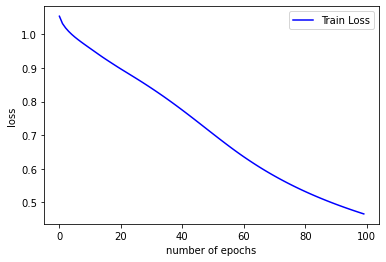

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(range(0, no_epochs), train_losses, color='blue')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('number of epochs')
plt.ylabel('loss')

### 4. Model Evaluation
Finally, we check the model accuracy on the test data. For this we predict on the test data, identify the class with the highest score and compare it to the true label.

In [11]:
predictions = net(test_x)
_, predicted = torch.max(predictions.data, 1) # get the class with highest score
correct = (predicted == test_y).sum().item() # compare predicted class with real class
print(f"Accuarcy is {100. * correct / len(test_x)}%")

Accuarcy is 76.66666666666667%
